In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load iris dataset
iris = datasets.load_iris()

# since this is a bunch, create a dataframe

iris_df=pd.DataFrame(iris.data)
iris_df['class']=iris.target
iris_df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
iris_df.dropna(how="all", inplace=True) # remove any empty lines
iris = iris_df.sample(frac=1).reset_index(drop=True)

print(iris)


     sepal_len  sepal_wid  petal_len  petal_wid  class
0          5.7        2.6        3.5        1.0      1
1          6.3        3.3        6.0        2.5      2
2          6.7        3.1        4.7        1.5      1
3          7.2        3.2        6.0        1.8      2
4          5.4        3.4        1.7        0.2      0
..         ...        ...        ...        ...    ...
145        5.7        3.8        1.7        0.3      0
146        6.3        2.5        4.9        1.5      1
147        6.3        2.8        5.1        1.5      2
148        6.4        3.2        4.5        1.5      1
149        6.0        3.0        4.8        1.8      2

[150 rows x 5 columns]


In [2]:
class Model:
    numberOfClasses = 0
    numberOfFeatures = 0
    numberOfHiddenLayerUnits = 0
    X = None
    Y = None
    X_forTraining = None
    X_forTesting = None
    Y_forTraining = None
    Y_forTesting = None
    Y_train_encoded = None
    Y_test_encoded = None
    W1 = None
    b1 = None
    W2 = None
    b2 = None
    splitRange = 75
    
    # One-hot encode the labels for categorical cross-entropy
    def one_hot_encode(self, labels, num_classes):
        return np.eye(num_classes)[labels]
        
    def prepareInputData(self, inputDataFrame: pd.DataFrame, numberOfClasses: int, numberOfFeatures: int, numberOfHiddenLayerUnits: int, splitRange):
        self.numberOfClasses = numberOfClasses
        self.numberOfFeatures = numberOfFeatures
        self.numberOfHiddenLayerUnits = numberOfHiddenLayerUnits

        print(self.numberOfHiddenLayerUnits)
        self.splitRange = splitRange
        self.X = inputDataFrame.iloc[:, 0:numberOfFeatures]
        self.Y = inputDataFrame.iloc[:, -1]
        
        
        self.X_forTraining, self.X_forTesting = self.X.iloc[:self.splitRange], self.X.iloc[self.splitRange:]
        self.Y_forTraining, self.Y_forTesting = self.Y.iloc[:self.splitRange], self.Y.iloc[self.splitRange:]

        self.Y_train_encoded = self.one_hot_encode(self.Y_forTraining, self.numberOfClasses)
        self.Y_test_encoded = self.one_hot_encode(self.Y_forTesting, self.numberOfClasses)

        # print(self.Y_test_encoded.shape)
        # print(self.Y_test_encoded)
        # print(self.Y_forTesting.shape)
        # print(self.Y_forTesting)
    
    def initializeStartParameters(self):
        np.random.seed(42)
        self.W1 = np.random.randn(self.numberOfFeatures, self.numberOfHiddenLayerUnits)

        print(self.W1)
        self.b1 = np.zeros((1, self.numberOfHiddenLayerUnits))
        self.W2 = np.random.randn(self.numberOfHiddenLayerUnits, self.numberOfClasses)
        self.b2 = np.zeros((1, self.numberOfClasses))
    
    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self,Z):
        return Z > 0

    def softmax(self,Z):
        Z = Z.to_numpy()
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def compute_loss(self,Y, Y_hat):
        m = Y.shape[0]
        return -np.sum(Y * np.log(Y_hat + 1e-9)) / m
    
    def forwardPropagation(self, X):
        Z1 = X.dot(self.W1) + self.b1
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.W2) + self.b2
        A2 = self.softmax(Z2)
        return {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    
    def backwardPropagation(self, X, Y, cache):
        m = X.shape[0]

        dZ2 = cache["A2"] - Y
        dW2 = (1 / m) * np.dot(cache["A1"].T, dZ2)
        # dW2 =  np.dot(cache["A1"].T, dZ2)  / m
        
        db2 = (1 / m) * np.sum(dZ2, axis=0, keepdims=True)
        dZ1 = np.dot(dZ2, self.W2.T) * self.relu_derivative(cache["Z1"])

        dW1 = (1 / m) * np.dot(X.T, dZ1)
        
        db1 = (1 / m) * np.sum(dZ1.to_numpy(), axis=0, keepdims=True)

        return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    def updateParameters(self, grads, learningRate):
        self.W1 -= learningRate * grads["dW1"]
        self.b1 -= learningRate * grads["db1"]
        self.W2 -= learningRate * grads["dW2"]
        self.b2 -= learningRate * grads["db2"]

    def evaluate( self):
        # Perform forward propagation to get predictions
        
        cache = self.forwardPropagation(self.X_forTesting)
        
        predictions = np.argmax(cache["A2"], axis=1)  # Choose the class with the highest probability
    
        # Calculate accuracy
        accuracy = np.mean(predictions == self.Y_forTesting) * 100  # Compare predictions to true labels and compute percentage
        
        return accuracy
        
    def evaluateFullDataset( self):
        # Perform forward propagation to get predictions
        cache = self.forwardPropagation(self.X)
        predictions = np.argmax(cache["A2"], axis=1)  # Choose the class with the highest probability

        # print(predictions.shape)
        # print(predictions)
        # print(self.Y.shape)
        # print(self.Y)

        
        # Calculate accuracy
        accuracy = np.mean(predictions == self.Y) * 100  # Compare predictions to true labels and compute percentage
        return accuracy

In [3]:
Iris = Model()
Iris.prepareInputData(iris, 3, 4, 1, 120)

1


In [4]:
import json
epochs=2000
learning_rate=0.082

Iris.initializeStartParameters()

for epoch in range(epochs):
    # Forward pass on training data
    train_cache = Iris.forwardPropagation(Iris.X_forTraining)
    
    loss = Iris.compute_loss(Iris.Y_train_encoded, train_cache["A2"])

    
    # Backward pass (compute gradients)
    grads = Iris.backwardPropagation(Iris.X_forTraining, Iris.Y_train_encoded, train_cache)
    
    # Update parameters
    Iris.updateParameters(grads, learning_rate)
    
    # Print the loss every 100 epochs
    if epoch % 100 == 0:
        test_cache = Iris.forwardPropagation(Iris.X_forTesting)
        test_loss = Iris.compute_loss(Iris.Y_test_encoded, test_cache["A2"])
        
        print(f"Epoch {epoch}, Training loss: {loss:.4f}, Test loss: {test_loss:.4f}")

accuracy = Iris.evaluate()


    
print(f"Accuracy: {accuracy :.2f}%")

[[ 0.49671415]
 [-0.1382643 ]
 [ 0.64768854]
 [ 1.52302986]]
Epoch 0, Training loss: 6.6069, Test loss: 1.0750
Epoch 100, Training loss: 0.5619, Test loss: 0.5304
Epoch 200, Training loss: 0.3874, Test loss: 0.4035
Epoch 300, Training loss: 0.3133, Test loss: 0.3440
Epoch 400, Training loss: 0.2659, Test loss: 0.3049
Epoch 500, Training loss: 0.2320, Test loss: 0.2769
Epoch 600, Training loss: 0.2067, Test loss: 0.2559
Epoch 700, Training loss: 0.1871, Test loss: 0.2398
Epoch 800, Training loss: 0.1715, Test loss: 0.2271
Epoch 900, Training loss: 0.1588, Test loss: 0.2167
Epoch 1000, Training loss: 0.1483, Test loss: 0.2082
Epoch 1100, Training loss: 0.1394, Test loss: 0.2010
Epoch 1200, Training loss: 0.1317, Test loss: 0.1948
Epoch 1300, Training loss: 0.1251, Test loss: 0.1895
Epoch 1400, Training loss: 0.1193, Test loss: 0.1849
Epoch 1500, Training loss: 0.1141, Test loss: 0.1808
Epoch 1600, Training loss: 0.1095, Test loss: 0.1772
Epoch 1700, Training loss: 0.1054, Test loss: 0.17

In [5]:
accuracy = Iris.evaluateFullDataset()

print(f"Accuracy: {accuracy :.2f}%")

print("W1:", json.dumps(Iris.W1.tolist()))
print()
print("W2:", json.dumps(Iris.W2.tolist()))
print()
print("b1:", json.dumps(Iris.b1.tolist()))
print()
print("b2:", json.dumps(Iris.b2.tolist()))



Accuracy: 98.00%
W1: [[-0.8783396589793361], [-1.2882996642945428], [1.8434411558679882], [3.43779511288891]]

W2: [[-2.8582598468405904, 1.279353331836048, 2.6898289988394195]]

b1: [[-0.49682828320253997]]

b2: [[4.4083343303152684, 1.2118430046766304, -5.620177334991885]]


[[ 0.49671415]
 [-0.1382643 ]
 [ 0.64768854]
 [ 1.52302986]]


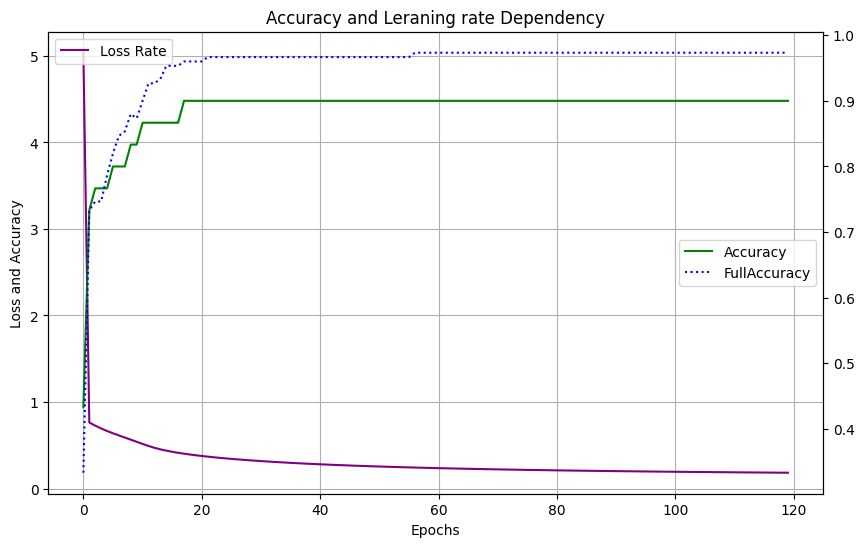

In [6]:
epochs=12000
learning_rate=0.01


lossValues = []
# LrValues = [] 
accuracyValues = []
fullAccuracyValues = []

Iris.initializeStartParameters()
for epoch in range(epochs):
    # Forward pass on training data
    train_cache = Iris.forwardPropagation(Iris.X_forTraining)
    
    loss = Iris.compute_loss(Iris.Y_train_encoded, train_cache["A2"])

    
    # Backward pass (compute gradients)
    grads = Iris.backwardPropagation(Iris.X_forTraining, Iris.Y_train_encoded, train_cache)
    
    # Update parameters
    Iris.updateParameters(grads, learning_rate)
    
    # Print the loss every 100 epochs
    if epoch % 100 == 0:
        test_cache = Iris.forwardPropagation(Iris.X_forTesting)
        test_loss = Iris.compute_loss(Iris.Y_test_encoded, test_cache["A2"])
        
        # print(f"Epoch {epoch}, Training loss: {loss:.4f}, Test loss: {test_loss:.4f}")

        lossValues.append(test_loss)

        accuracy = Iris.evaluate()
        fullAccuracy = Iris.evaluateFullDataset()
        accuracyValues.append(accuracy/100)
        fullAccuracyValues.append(fullAccuracy/100)

# Plotting the list
plt.figure(figsize=(10, 6))
plt.title('Accuracy and Leraning rate Dependency')
plt.xlabel('Epochs')
plt.ylabel('Loss and Accuracy')
plt.grid(True)

plt.plot(lossValues,  linestyle='-', color='purple', label='Loss Rate')
plt.legend(loc='upper left')
# Create a second y-axis for the second list

ax2 = plt.twinx()
ax2.plot(accuracyValues,  linestyle='-', color='green', label='Accuracy')
# Adding legends for both plots
ax2.plot(fullAccuracyValues,  linestyle=':', color='blue', label='FullAccuracy')
ax2.legend(loc='center right')

# Create a second y-axis for the second list
# ax2 = plt.twinx()
# ax2.plot(LrValues, marker='o', linestyle='--', color='red', label='Learning Rate')
# ax2.set_ylabel('Learning Rate', color='red')

plt.show()
accuracyValues = []
fullAccuracyValues = []
lossValues = []

[[ 0.49671415]
 [-0.1382643 ]
 [ 0.64768854]
 [ 1.52302986]]
Accuracy :90.0
Accuracy Full Dataset :96.0
[[ 0.49671415]
 [-0.1382643 ]
 [ 0.64768854]
 [ 1.52302986]]
Accuracy :90.0
Accuracy Full Dataset :96.66666666666667
[[ 0.49671415]
 [-0.1382643 ]
 [ 0.64768854]
 [ 1.52302986]]
Accuracy :90.0
Accuracy Full Dataset :97.33333333333334
[[ 0.49671415]
 [-0.1382643 ]
 [ 0.64768854]
 [ 1.52302986]]
Accuracy :90.0
Accuracy Full Dataset :97.33333333333334
[[ 0.49671415]
 [-0.1382643 ]
 [ 0.64768854]
 [ 1.52302986]]
Accuracy :90.0
Accuracy Full Dataset :97.33333333333334
[[ 0.49671415]
 [-0.1382643 ]
 [ 0.64768854]
 [ 1.52302986]]
Accuracy :90.0
Accuracy Full Dataset :97.33333333333334
[[ 0.49671415]
 [-0.1382643 ]
 [ 0.64768854]
 [ 1.52302986]]
Accuracy :93.33333333333333
Accuracy Full Dataset :98.0
[[ 0.49671415]
 [-0.1382643 ]
 [ 0.64768854]
 [ 1.52302986]]
Accuracy :93.33333333333333
Accuracy Full Dataset :98.0
[[ 0.49671415]
 [-0.1382643 ]
 [ 0.64768854]
 [ 1.52302986]]
Accuracy :93.333

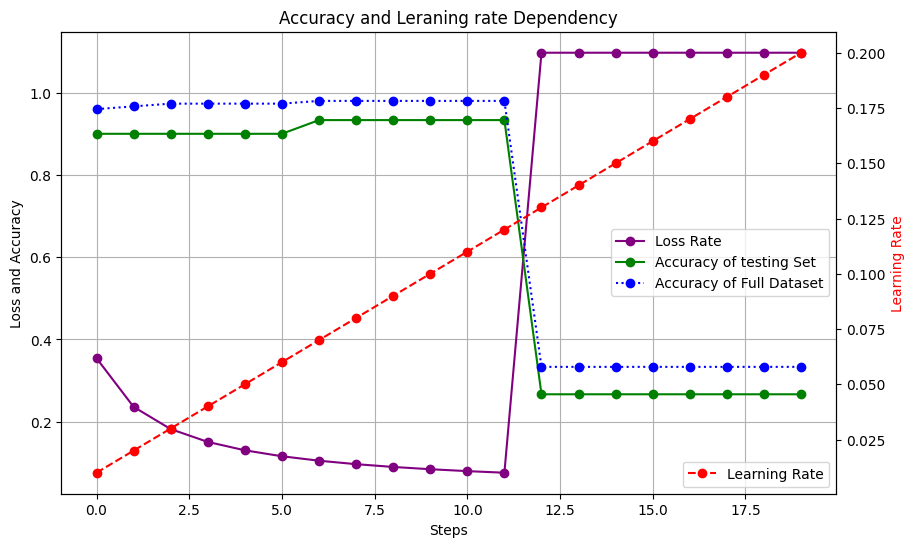

In [7]:
epochs=2000
tests = 20
learning_rate=0.01


lossValues = []
LrValues = []
accuracyValues = []
fullAccuracyValues = []

for test in range(tests):
    Iris.initializeStartParameters()
    for epoch in range(epochs):
        # Forward pass on training data
        train_cache = Iris.forwardPropagation(Iris.X_forTraining)
        
        loss = Iris.compute_loss(Iris.Y_train_encoded, train_cache["A2"])
    
        
        # Backward pass (compute gradients)
        grads = Iris.backwardPropagation(Iris.X_forTraining, Iris.Y_train_encoded, train_cache)
        
        # Update parameters
        Iris.updateParameters(grads, learning_rate)
        
        # Print the loss every 100 epochs
        if epoch % 100 == 0:
            test_cache = Iris.forwardPropagation(Iris.X_forTesting)
            test_loss = Iris.compute_loss(Iris.Y_test_encoded, test_cache["A2"])
            
            # print(f"Epoch {epoch}, Training loss: {loss:.4f}, Test loss: {test_loss:.4f}")
    LrValues.append(learning_rate)
    learning_rate += 0.01
    
    lossValues.append(loss)
    
    accuracy = Iris.evaluate()
    fullAccuracy = Iris.evaluateFullDataset()
    accuracyValues.append(accuracy/100)
    fullAccuracyValues.append(fullAccuracy/100)

    print(f"Accuracy :{accuracy}")
    print(f"Accuracy Full Dataset :{fullAccuracy}")
    
    # print(f"Accuracy: {accuracy :.2f}%")


# Plotting the list
plt.figure(figsize=(10, 6))
plt.xlabel('Steps')
plt.title('Accuracy and Leraning rate Dependency')
plt.ylabel('Loss and Accuracy')
plt.grid(True)

plt.plot(lossValues, marker='o', linestyle='-', color='purple', label='Loss Rate')
plt.plot(accuracyValues, marker='o', linestyle='-', color='green', label='Accuracy of testing Set')
plt.plot(fullAccuracyValues, marker='o', linestyle=':', color='blue', label='Accuracy of Full Dataset')

plt.legend(loc='center right')
# plt.legend(['Accuracy'], loc='upper left')

# Create a second y-axis for the second list
ax2 = plt.twinx()
ax2.plot(LrValues, marker='o', linestyle='--', color='red', label='Learning Rate')
ax2.set_ylabel('Learning Rate', color='red')

# Adding legends for both plots
ax2.legend( loc='lower right')

plt.show()
accuracyValues = []
fullAccuracyValues = []
lossValues = []

In [8]:
# epochs=1000
# tests = 64
# learning_rate=0.01


# lossValues = []
# neurons = 1
# neurons_array = []
# accuracyValues = []
# fullAccuracyValues = []


# for test in range(tests):
    
#     Iris.initializeStartParameters()
#     Iris.numberOfHiddenLayerUnits = neurons
    
#     for epoch in range(epochs):
#         # Forward pass on training data
#         train_cache = Iris.forwardPropagation(Iris.X_forTraining)
        
#         loss = Iris.compute_loss(Iris.Y_train_encoded, train_cache["A2"])
    
        
#         # Backward pass (compute gradients)
#         grads = Iris.backwardPropagation(Iris.X_forTraining, Iris.Y_train_encoded, train_cache)
        
#         # Update parameters
#         Iris.updateParameters(grads, learning_rate)
        
#         # Print the loss every 100 epochs
#         if epoch % 100 == 0:
#             test_cache = Iris.forwardPropagation(Iris.X_forTesting)
#             test_loss = Iris.compute_loss(Iris.Y_test_encoded, test_cache["A2"])
            
#             # print(f"Epoch {epoch}, Training loss: {loss:.4f}, Test loss: {test_loss:.4f}")
#     neurons_array.append(neurons)
#     neurons += 1

    
#     lossValues.append(loss)
    
#     accuracy = Iris.evaluate()
#     fullAccuracy = Iris.evaluateFullDataset()
#     accuracyValues.append(accuracy/100)
#     fullAccuracyValues.append(fullAccuracy/100)
    
#     # print(f"Accuracy: {accuracy :.2f}%")

# # x = range(1, neurons_array)
# # Plotting the list
# plt.figure(figsize=(10, 6))
# plt.xlabel('Epochs X Steps')
# plt.title('Accuracy and Leraning rate Dependency')
# plt.ylabel('Loss and Accuracy')
# plt.grid(True)

# plt.plot(lossValues, marker='o', linestyle='-', color='purple', label='Loss Rate')
# plt.plot(accuracyValues, marker='o', linestyle='-', color='green', label='Accuracy of testing Set')
# plt.plot(fullAccuracyValues, marker='o', linestyle=':', color='blue', label='Accuracy of Full Dataset')

# plt.legend()
# # plt.legend(['Accuracy'], loc='upper left')

# # Create a second y-axis for the second list
# ax2 = plt.twinx()
# ax2.plot(neurons_array, marker='o', linestyle='--', color='red', label='neurons amount')
# ax2.set_ylabel('Learning Rate', color='red')

# # Adding legends for both plots
# ax2.legend( loc='lower right')

# plt.show()
# accuracyValues = []
# fullAccuracyValues = []
# lossValues = []